# Modules

In [1]:
def create_lattice(m):
    '''
    Generates an m x m array, where each element is (pseudo)randomly assigned a value of either 1 or -1. The array is
    thus a simulation of an m x m lattice with a (pseudo)randomly determined configuration of +1 spins and -1 spins. 
    '''
    lattice = np.random.choice([1,-1], size=(m,m))
    return lattice

In [2]:
def sweep(S, J_kT, B_kT):
    '''
    Outputs an m x m array representing the subsequent configuration of the spins after one 'sweep' across the 
    inputted array S_init. A 'sweep' is the process of flipping or not flipping the spin of every array element, 
    with the decision to flip or not to flip being based on the Metropolis-Hastings algorithm. J_kT = J/(k_B*T), 
    and B_kT = B/(k_B*T).
    '''
    m = S.shape[0]
    list_randomrowindices = np.random.choice(m, m, replace=False).tolist()
    list_randomcolumnindices = np.random.choice(m, m, replace=False).tolist()
    
    for i in list_randomrowindices:
        for j in list_randomcolumnindices:
            s = S[i,j] #pick a random element from S_init (without replacement).
            neighbour_sum = S[i,(j+1)%m] + S[i,(j-1)%m] + S[(i+1)%m,j] + S[(i-1)%m,j] #compute sum of immediately
            #...neighbouring spins. The modulo operations help impose the periodic boundary conditions, which say that
            #...for any particular row/column in the array, its first element would be a neighbour of its last element,
            #...and vice versa. We can visualise how this works by imagining the array as a 2D sheet and folding it into
            #...a torus.
            delta_E_kT = J_kT*2*s*neighbour_sum + B_kT*2*s #compute change in (effective) energy. The factor of 2 exists
            #...because if s were flipped, the magnitude of the change in energy would be equal to twice the initial energy.
            if delta_E_kT <= 0:
                s *= -1
            elif np.random.rand() < np.exp(-delta_E_kT):
                s *= -1
            S[i,j] = s
    return S.copy()

In [3]:
def calc_magnetic_moment(S):
    '''
    Calculates the magnetic moment.
    '''
    return np.sum(S)

In [5]:
def get_critical_value(x_list, y_list):
    '''
    Returns the value in x_list corresponding to the value in y_list for which the sum of the differences between itself 
    and its nearest-neighbouring values is the greatest.
    '''
    y_diff_list = []
    y_index_max = len(y_list)-1
    y_index_list = list(range(1,y_index_max))
    for y_index in y_index_list:
        y_diff = y_list[y_index+1] - y_list[y_index-1]
        y_diff_list.append(y_diff)
    y_diff_max = max(y_diff_list)
    y_diff_max_index = y_diff_list.index(y_diff_max)
    critical_value_index = y_index_list[y_diff_max_index]
    critical_value = x_list[critical_value_index]
    return critical_value

In [6]:
def plot_configuration(state, sweep_count):
    '''
    Produces a colour map representing the configuration (lattice) of spins. Saves the colour map to /Pictures folder. 
    '''
    plt.figure(figsize=(7, 7), dpi=100)
    plt.imshow(state, cmap=plt.cm.get_cmap('jet', 2), origin='lower')
    plt.colorbar(ticks=[-1,0,1], label='Spin', extend='both')
    plt.title('Configuration after sweep number {}'.format(sweep_count), fontsize=17)

In [7]:
def plot_data(x_list, y_list, title_str, x_label_str, y_label_str):
    '''
    Plots y_list (list of values for dependent variable) against x_list (list of values for independent variable). 
    '''
    plt.figure(figsize=(7, 7), dpi=100)
    plt.plot(x_list, y_list, 'bo', markersize=2)
    plt.title(title_str, fontsize=17)
    plt.xlabel(x_label_str, fontsize=14)
    plt.ylabel(y_label_str, fontsize=14)
    plt.show()

In [8]:
def plot_special_data(x_list, y_list, title_str, x_label_str, y_label_str):
    '''
    Plots y_list (list of values for dependent variable) against x_list (list of values for independent variable).
    This module is specially for plotting M against J/(k_B*T).
    '''
    plt.figure(figsize=(7, 7), dpi=100)
    plt.plot(x_list, y_list, 'bo', markersize=2)
    plt.axvline(x=0.44, linewidth=1, color='r', alpha=0.8)
    plt.axvline(x=get_critical_value(x_list, y_list), linewidth=1, color='g', alpha=0.8)
    plt.title(title_str, fontsize=17)
    plt.xlabel(x_label_str, fontsize=14)
    plt.ylabel(y_label_str, fontsize=14)
    plt.show()

In [9]:
def overlay_plot_with_errorbars(x_list, y_list, y_error_list, title_str, x_label_str, y_label_str):
    '''
    Overlay of plot of y_list (list of values for dependent variable) against x_list (list of values for independent... 
    variable) and plot of analytically-derived relation between M and J/(k_B*T).
    This module is specially for a particular plot of M against J/(k_B*T), with error bars included.
    '''
    plt.figure(figsize=(7, 7), dpi=100)
    plt.plot(x_list, y_list, 'bo', markersize=2, label='Computational Result')
    plt.errorbar(x_list, y_list, yerr=y_error_list, fmt='bo', markersize=2, color='blue', ecolor='blue', elinewidth=1, capsize=3)
    input_list = [i * 2 for i in x_list]
    M_list = (1 - (np.sinh(input_list))**(-4))**(1/8)
    plt.plot(x_list, M_list, 'ro', markersize=2, label='Analytical Result')
    plt.title(title_str, fontsize=17)
    plt.xlabel(x_label_str, fontsize=14)
    plt.ylabel(y_label_str, fontsize=14)
    plt.legend(loc='lower right')
    plt.show()

In [10]:
def run_simulation(S_0, J_kT, B_kT, sweep_total):
    '''
    Performs the simulation by sweeping across an initial lattice S_0 a number of times (number = sweep_total). 
    Returns a list of relevant values (e.g., the stabilised magnetisation). 
    '''
    M_list = []
    M_abs_list = []
    M_cumulative_list = []
    sweep_count_list = []
    S_colormap_list = []
    colormap_sweep_count_list = []

    
    # To avoid effect of initial state
    for count in range(50):
        S_init = sweep(S_0, J_kT, B_kT)


    # Start proper sweep
    for sweep_count in range(sweep_total + 1):
        S_next = sweep(S_init, J_kT, B_kT)
        S_init = S_next
        M = calc_magnetic_moment(S_next)
        M_list.append(M)
        M_cumulative_list.append(sum(M_list))
        M_abs = abs(M)
        M_abs_list.append(M_abs)
        sweep_count_list.append(sweep_count)
    
        if (sweep_count) % (sweep_total/8) == 0:
        # Extract S_next at 8 different stages to plot the color maps later
            S_colormap_list.append(S_next)
            colormap_sweep_count_list.append(sweep_count)
   

    # Obtain a list of |M| values from the 500th sweep till the last sweep. |M| is assumed to have reached a stable value by
    #...the 500th sweep; we make this supposition based on prior plots of |M| against sweep number for different values of 
    #...J/k_BT and B/k_BT.
    stable_M_abs_histogram_data = M_abs_list[500:]

    # Fit a normal distribution to the list of values of |M|, and compute the mean and standard deviation. 
    mu, std = norm.fit(stable_M_abs_histogram_data)
    
    return [mu, std, M_list, M_cumulative_list, M_abs_list, sweep_count_list, S_colormap_list, colormap_sweep_count_list]

# Implementation

In [11]:
# Import relevant libraries
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib import rc

rc('text', usetex=True)

C:\Users\richa\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in power
  # This is added back by InteractiveShellApp.init_path()


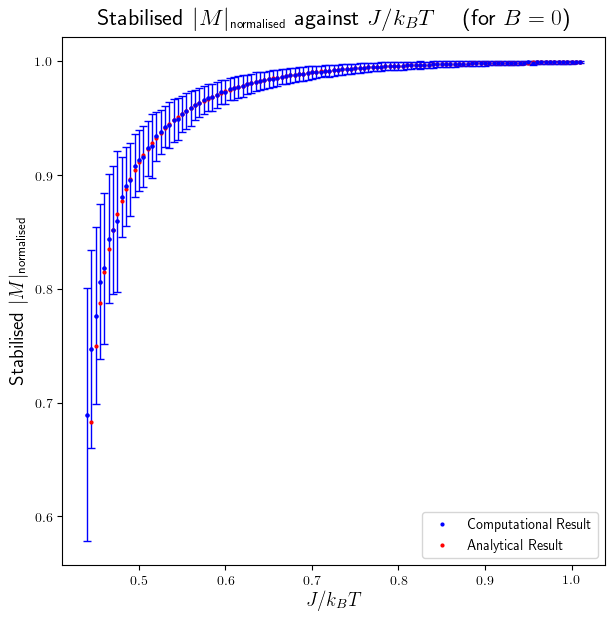

In [11]:
# Initialise variables
S_0 = create_lattice(30)
B_kT = 0 # try the following values of B_kT: 0, 0.001, 0.01
J_kT_list = np.arange(0.44, 1.01, 0.005).tolist()
sweep_total = 2000
stable_M_abs_normalised_mean_list = []
stable_M_abs_normalised_mean_error_list = []


# Obtain lists of magnetisation values and their standard deviations for different values of J/(k_B*T)
for J_kT in J_kT_list:
    list_relevantvalues = run_simulation(S_0, J_kT, B_kT, sweep_total)
    magnetisation = list_relevantvalues[0]
    magnetisation_error = list_relevantvalues[1]
    stable_M_abs_normalised_mean_list.append(magnetisation/900)
    stable_M_abs_normalised_mean_error_list.append(magnetisation_error/900)


# Output overlay of plots of analytical and computational results for stable magnetic moment against J/(k_B*T)
overlay_plot_with_errorbars(J_kT_list, stable_M_abs_normalised_mean_list, stable_M_abs_normalised_mean_error_list, "Stabilised $|M|_{\small \mbox{normalised}}$ against $J/k_BT$ $\hspace{5mm}$(for $B=0$)", "$J/k_BT$", "Stabilised $|M|_{\small \mbox{normalised}}$")

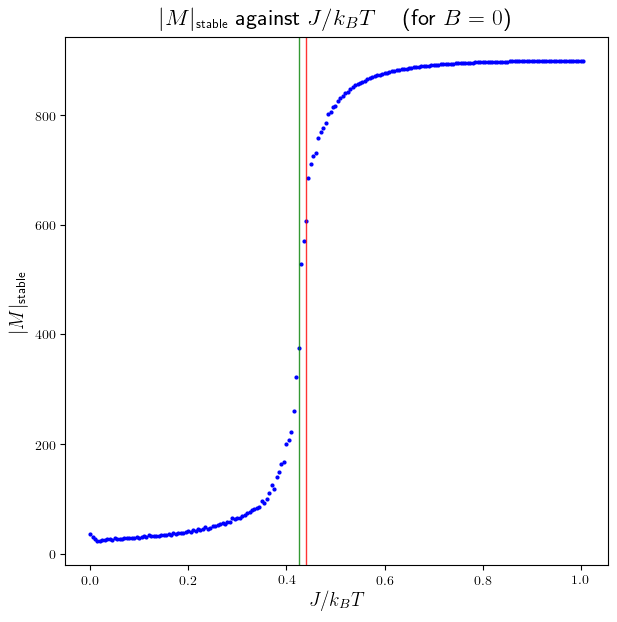

The estimated critical value of J/(k_B*T) at which phase transition occurs is: 0.425


In [100]:
# Initialise variables
S_0 = create_lattice(30)
B_kT = 0 # try the following values of B_kT: 0, 0.001, 0.01
J_kT_list = np.arange(0, 1.01, 0.005).tolist()
sweep_total = 2000
stable_M_abs_mean_list = []


# Obtain a list of magnetisation values for different values of J/(k_B*T)
for J_kT in J_kT_list:
    list_relevantvalues = run_simulation(S_0, J_kT, B_kT, sweep_total)
    magnetisation = list_relevantvalues[0]
    stable_M_abs_mean_list.append(magnetisation)
    

# Output plot of stable magnetic moment against J/(k_B*T). 
# red, vertical line marks out the analytically derived critical value of J/(k_B*T) ~ 0.44 (when B = 0).
# The green, vertical line provides a (rough) indication of where the phase transition might have occurred.
plot_special_data(J_kT_list, stable_M_abs_mean_list, "$|M|_{\small \mbox{stable}}$ against $J/k_BT$ $\hspace{5mm}$(for $B=0$)", "$J/k_BT$", "$|M|_{\small \mbox{stable}}$")


# Print (approximate) critical value for the phase transition. Corresponds to green, vertical line.
Critical_Value = get_critical_value(J_kT_list, stable_M_abs_mean_list)
print("The estimated critical value of J/(k_B*T) at which phase transition occurs is: " + str(Critical_Value))

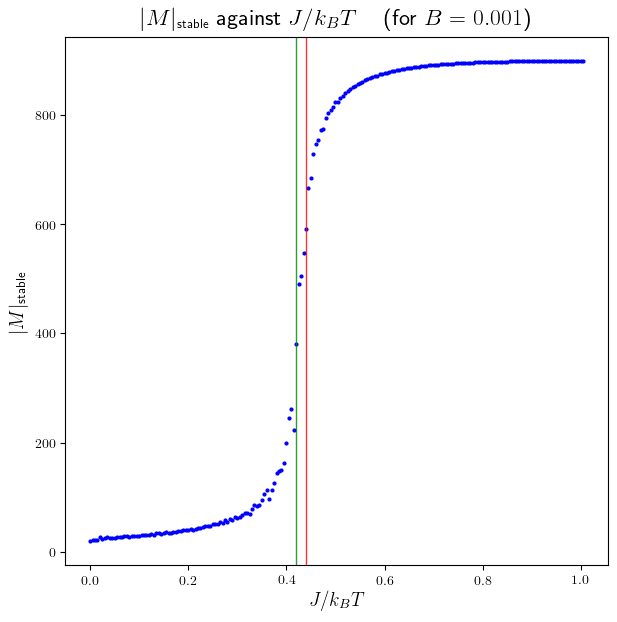

The estimated critical value of J/(k_B*T) at which phase transition occurs is: 0.42


In [101]:
# Initialise variables
S_0 = create_lattice(30)
B_kT = 0.001 # try the following values of B_kT: 0, 0.001, 0.01
J_kT_list = np.arange(0, 1.01, 0.005).tolist()
sweep_total = 2000
stable_M_abs_mean_list = []


# Obtain a list of magnetisation values for different values of J/(k_B*T)
for J_kT in J_kT_list:
    list_relevantvalues = run_simulation(S_0, J_kT, B_kT, sweep_total)
    magnetisation = list_relevantvalues[0]
    stable_M_abs_mean_list.append(magnetisation)
    

# Output plot of stable magnetic moment against J/(k_B*T). 
#The red, vertical line marks out the analytically derived critical value of J/(k_B*T) ~ 0.44 (when B = 0).
#The green, vertical line provides a (rough) indication of where the phase transition might have occurred.
plot_special_data(J_kT_list, stable_M_abs_mean_list, "$|M|_{\small \mbox{stable}}$ against $J/k_BT$ $\hspace{5mm}$(for $B=0.001$)", "$J/k_BT$", "$|M|_{\small \mbox{stable}}$")


# Print (approximate) critical value for the phase transition. Corresponds to green, vertical line.
Critical_Value = get_critical_value(J_kT_list, stable_M_abs_mean_list)
print("The estimated critical value of J/(k_B*T) at which phase transition occurs is: " + str(Critical_Value))

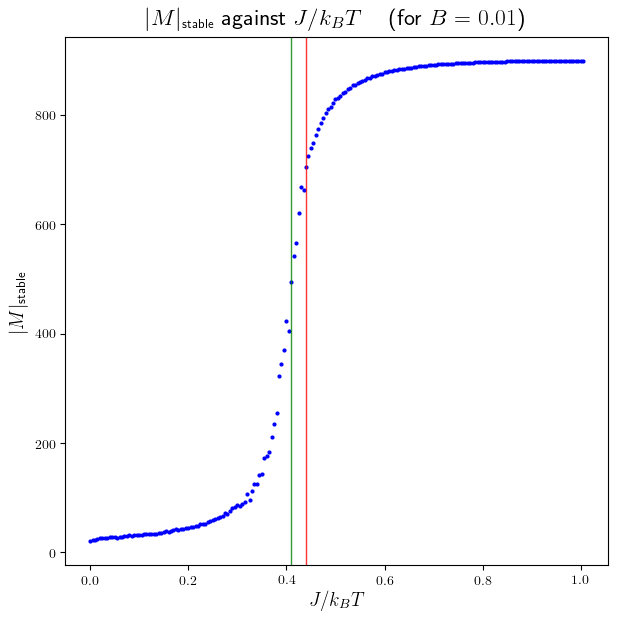

The estimated critical value of J/(k_B*T) at which phase transition occurs is: 0.41000000000000003


In [102]:
# Initialise variables
S_0 = create_lattice(30)
B_kT = 0.01 # try the following values of B_kT: 0, 0.001, 0.01
J_kT_list = np.arange(0, 1.01, 0.005).tolist()
sweep_total = 2000
stable_M_abs_mean_list = []


# Obtain a list of magnetisation values for different values of J/(k_B*T)
for J_kT in J_kT_list:
    list_relevantvalues = run_simulation(S_0, J_kT, B_kT, sweep_total)
    magnetisation = list_relevantvalues[0]
    stable_M_abs_mean_list.append(magnetisation)
    

# Output plot of stable magnetic moment against J/(k_B*T). 
#The red, vertical line marks out the analytically derived critical value of J/(k_B*T) ~ 0.44 (when B = 0).
#The green, vertical line provides a (rough) indication of where the phase transition might have occurred.
plot_special_data(J_kT_list, stable_M_abs_mean_list, "$|M|_{\small \mbox{stable}}$ against $J/k_BT$ $\hspace{5mm}$(for $B=0.01$)", "$J/k_BT$", "$|M|_{\small \mbox{stable}}$")


# Print (approximate) critical value for the phase transition. Corresponds to green, vertical line.
Critical_Value = get_critical_value(J_kT_list, stable_M_abs_mean_list)
print("The estimated critical value of J/(k_B*T) at which phase transition occurs is: " + str(Critical_Value))

In [14]:
# Initialise variables
S_0 = create_lattice(30)
B_kT = 0 # try any of the following values of B_kT: 0, 0.001, 0.01
J_kT = 0.65 # try any value between 0 and 1 (inclusive)
sweep_total = 1000

# Run simulation for selected values (above) and obtain relevant data
list_relevantvalues = run_simulation(S_0, J_kT, B_kT, sweep_total)
[mu, std, M_list, M_cumulative_list, M_abs_list, sweep_count_list, S_colormap_list, colormap_sweep_count_list] = list_relevantvalues

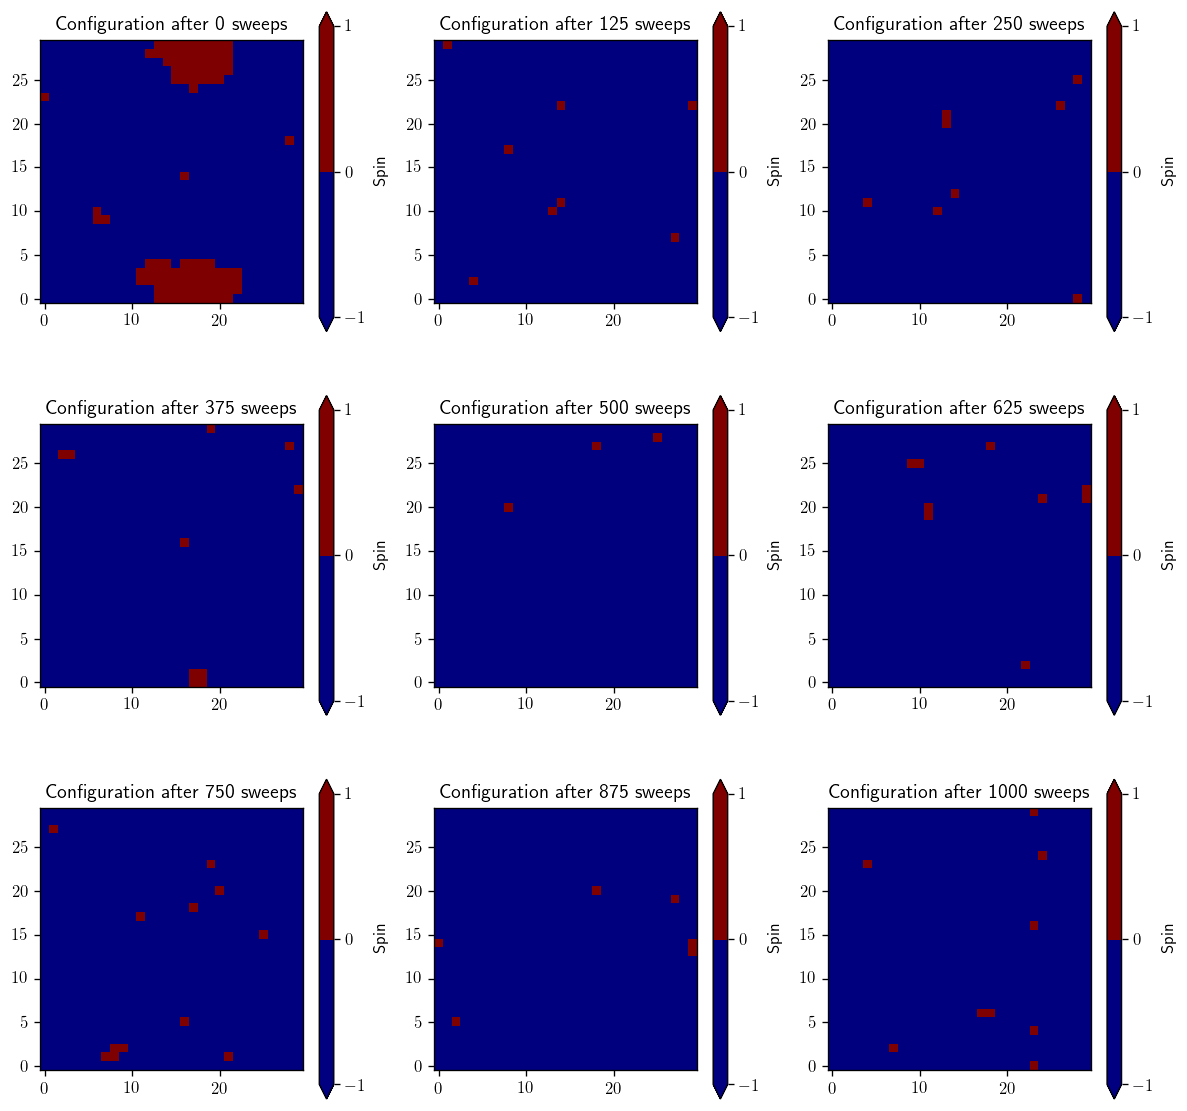

In [15]:
# Output color maps
fig = plt.figure(figsize=(12, 12), dpi = 120)
columns = 3
rows = 3
for i in range(1, columns*rows + 1):
    state = S_colormap_list[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(state, cmap=plt.cm.get_cmap('jet', 2), origin='lower')
    colormap_sweep_count = colormap_sweep_count_list[i-1]
    plt.title('Configuration after {} sweeps'.format(colormap_sweep_count))
    plt.colorbar(ticks=[-1,0,1], label='Spin', extend='both')

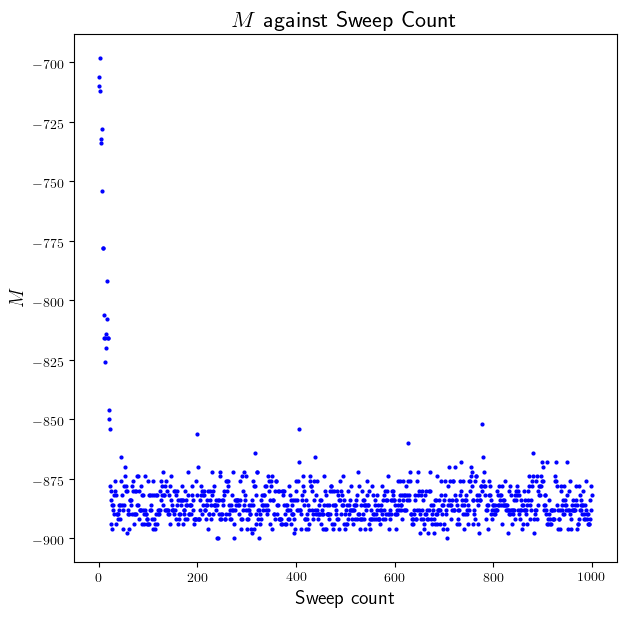

In [16]:
# Output plot of magnetic moment M against sweep count
plot_data(sweep_count_list, M_list, "$M$ against Sweep Count", "Sweep count", r"$M$")

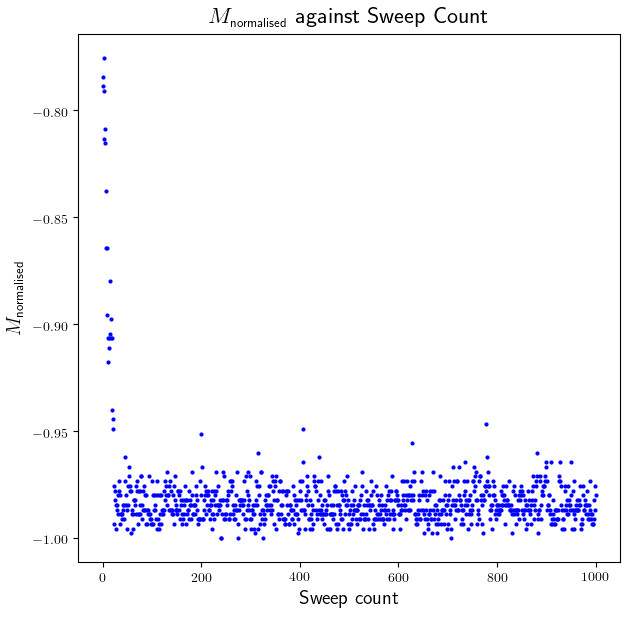

In [17]:
# Output plot of normalised magnetic moment M/M_max against sweep count
M_normalised_list = [i/900 for i in M_list]
plot_data(sweep_count_list, M_normalised_list, "$M_{\small \mbox{normalised}}$ against Sweep Count", "Sweep count", r"$M_{\small \mbox{normalised}}$")

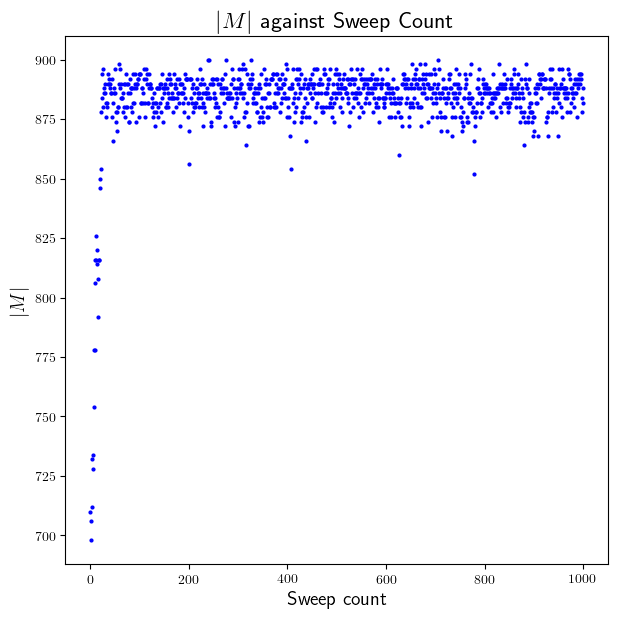

In [18]:
# Output plot of absolute value of magnetic moment |M| against sweep count
plot_data(sweep_count_list, M_abs_list, "$|M|$ against Sweep Count", "Sweep count", r"$|M|$")

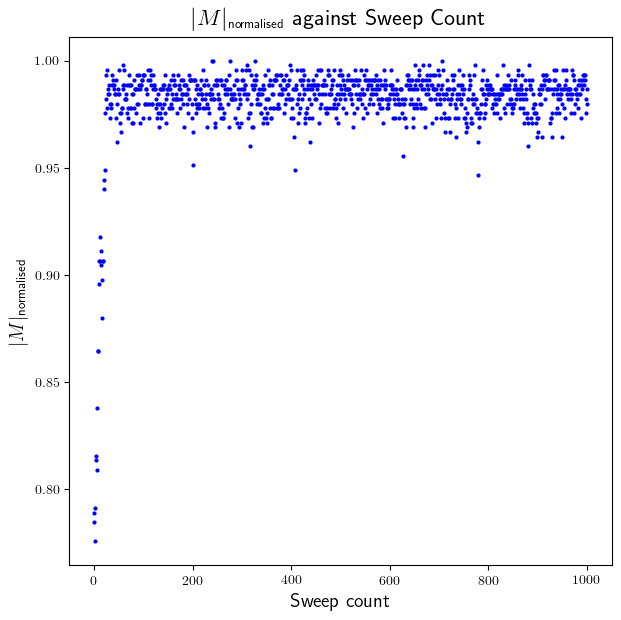

In [19]:
# Output plot of normalised absolute value of magnetic moment |M|/|M|_max against sweep count
M_abs_normalised_list = [i/900 for i in M_abs_list]
plot_data(sweep_count_list, M_abs_normalised_list, "$|M|_{\small \mbox{normalised}}$ against Sweep Count", "Sweep count", r"$|M|_{\small \mbox{normalised}}$")

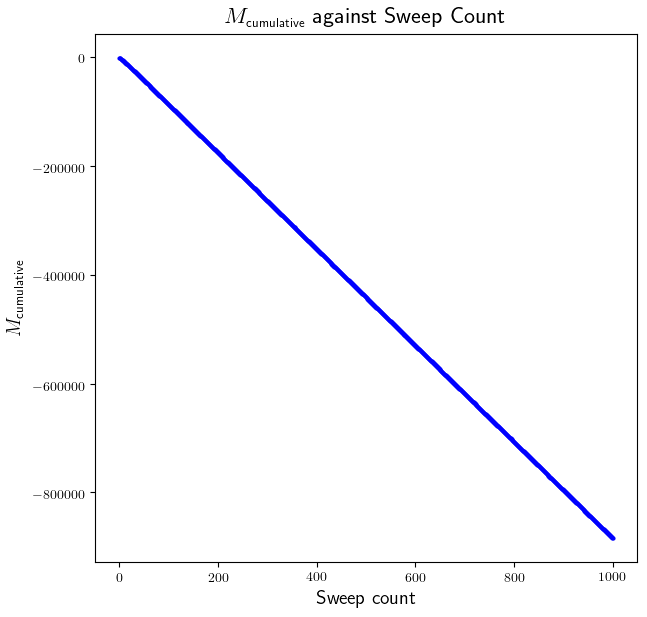

In [20]:
# Output plot of cumulative magnetic moment M_cumulative against sweep count
plot_data(sweep_count_list, M_cumulative_list, "$M_{\small \mbox{cumulative}}$ against Sweep Count", "Sweep count", r"$M_{\small \mbox{cumulative}}$")

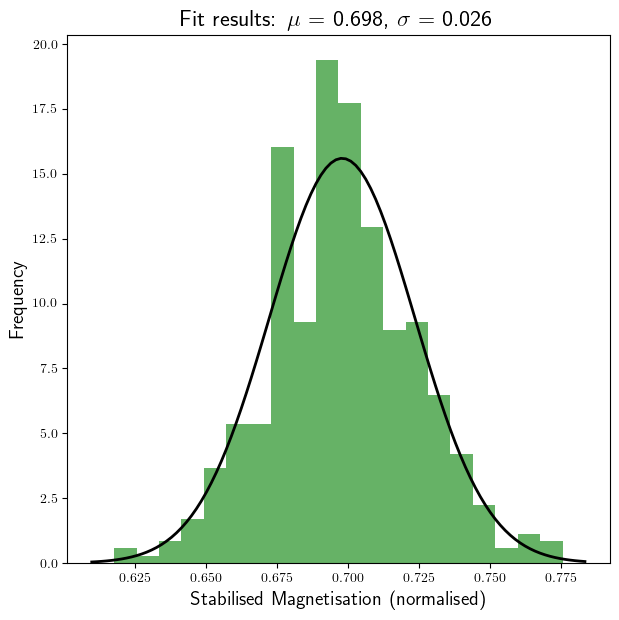

In [61]:
# Plots the distribution of (stabilised) magnetisation values. Just for visualisation purposes.


M_abs_normalised_mean_list = []

# Obtain a list of |M| values from the 500th sweep till the last sweep. |M| is assumed to have reached a stable value by
#...the 500th sweep; we make this supposition based on prior plots of |M| against sweep number for different values of 
#...J/k_BT and B/k_BT. Of course, the number can be changed on discretion.
M_abs_normalised_histogram_data = M_abs_normalised_list[500:]

# Fit a normal distribution to the list of values of |M|, and compute the mean and standard deviation. 
mu, std = norm.fit(M_abs_normalised_histogram_data)

# Save the value of the mean.
M_abs_normalised_mean_list.append(mu)

# Set the size of the plot.
plt.figure(figsize=(7, 7), dpi=100)

# Plot the histogram.
plt.hist(M_abs_normalised_histogram_data, bins=20, density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.xlabel('Stabilised Magnetisation (normalised)', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)
title = "Fit results: $\mu$ = %.3f,  $\sigma$ = %.3f" % (mu, std)
plt.title(title, fontsize = 17)
plt.show()